In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.algorithms.components import connected_components
from networkx.utils import not_implemented_for
from networkx.algorithms.cluster import triangles

In [2]:
from torch.utils.data import Dataset
from botdet.data.dataloader import GraphDataLoader
import deepdish as dd
from tqdm import tqdm
import os
import torch as ch
import random
import numpy as np
import dgl

Using backend: pytorch


In [3]:
import autotime
import snap
import matplotlib.pyplot as plt

In [4]:
@not_implemented_for("directed")
def average_clustering_ingoring_self_loops(G, trials=1000, seed=None):
    n = len(G)
    
    if trials >= n:
        raise ValueError("Requesting more trials than graph size - compute directly instead")

    triangles = 0
    nodes = list(G)

    # Pick N nodes at random (can repeat)
    random_nodes = np.random.choice(n, trials)
    
    for i in random_nodes:
        nbrs = list(G[nodes[i]])

        # Do not consider self loops, if present
        if nodes[i] in nbrs:
            nbrs.remove(nodes[i])

        # Not valid if one neighbor
        if len(nbrs) < 2:
            continue

        # Pick 2 neighbors at random
        u, v = np.random.choice(nbrs, 2, replace=False)
        
        # Check if they are connected
        if u in G[v]:
            triangles += 1
        
    return triangles / float(trials)

In [5]:
prefix = "/p/adversarialml/as9rw/datasets/raw_botnet/"

In [ ]:
f = prefix + "equinix-nyc.dirA.20181220-131800.UTC.anon.hdf5"
g = dd.io.load(f)

In [ ]:
# Get corresponding SNAP graph
sg = snap.TUNGraph.New()
for i in g.nodes:
    sg.AddNode(i)

for e in tqdm(g.edges):
    sg.AddEdge(int(e[0]), int(e[1]))

In [ ]:
# Get heuristic
sg.GetClustCf(False, 20000)

In [ ]:
# Add self loops
g.add_edges_from([(x, x) for x in g.nodes])

In [ ]:
# Check if code modification worked
average_clustering_ingoring_self_loops(g, 20000)

In [ ]:
trians = np.array([triangles(g, x) for x in g.nodes])
sorted_ids = np.argsort(-trians)

In [ ]:
np.mean(trians)

In [ ]:
n_tries = 1000

coeffs = []
for j in tqdm(range(n_tries)):
    coeffs.append(average_clustering_ingoring_self_loops(g, 20000))

In [ ]:
np.mean(coeffs)

In [ ]:
average_clustering_ingoring_self_loops(g, 20000)

In [ ]:
# Will make underlying graph more like a botnet - can be problematic
def remove_node_keep_connected(graph, node):
    neighbors = graph[node]
    edges_to_add = [(u, v) for u in neighbors for v in neighbors]
    # Form connections between neighbors to compensate for pruned node
    graph.add_edges_from(edges_to_add)
    # Prune node
    graph.remove_node(node)

In [ ]:
def modify_clustering_coefficient(graph, coeff,
                                  n_trials=10000, together=1000,
                                  m_trials=10, p_check=0.8,
                                  at_most=200000, verbose=True):

    # Get clustering coefficient starting with
    ca = average_clustering_ingoring_self_loops(graph, trials=n_trials)

    if verbose:
        print(graph.number_of_nodes(), "nodes,", graph.number_of_edges(), "edges")
        print("%d trials" % n_trials)
        print("Initial clustering coefficient: %f" % ca)

    # Iterate through nodes
    iterator = tqdm(range(0, at_most, together))
    for i in iterator:
        
        # Randomly pick edges to prune
        edges_to_prune = np.random.choice(len(graph.edges), together, replace=False)
        
        # Prune said edges
        graph.remove_edges_from(np.array(graph.edges)[edges_to_prune])
        
        # Get approximate clustering coefficient
        ca = average_clustering_ingoring_self_loops(graph, trials=n_trials)

        if verbose:
            iterator.set_description(
                "Clustering-coefficient: %.3f | %d" %
                (ca, graph.number_of_edges()))

        # If coefficient drops to desired value, run 'm_trials' more trials
        # if all of them satisfy desired coefficient, return graph
        if ca <= coeff:

            satisfy = 0
            for j in range(m_trials):
                ca_ = average_clustering_ingoring_self_loops(
                    graph, trials=n_trials)
                satisfy += (ca_ <= coeff)

            # If 'p_check' of them satisfy required coefficient requirement
            # return current graph
            if verbose:
                print("Got until", satisfy / m_trials)
            if (satisfy / m_trials) >= p_check:

                # Consider only largest component of pruned graph
                largest_cc = max(connected_components(graph), key=len)
                graph_ = graph.subgraph(largest_cc).copy()
                if verbose:
                    print("Numer of nodes decreased from %d to %d" %
                         (graph.number_of_nodes(), graph_.number_of_nodes()))
                    print("CC rn: %.3f" % average_clustering_ingoring_self_loops(graph_, trials=n_trials))

                return graph_

    # If nothing happened until this point, desired coefficient
    # was not achieved - raise error
    raise ValueError("Desired coefficient not achieved!")

In [ ]:
def density_preserving_node_prune(graph, n_prune, at_a_time=100, resync_every=10, verbose=True):

    if verbose:
        print(graph.number_of_nodes(), "nodes,", graph.number_of_edges(), "edges")

    # Iterate through nodes
    pwnd = 0
    start_deg = graph.number_of_edges() / graph.number_of_nodes()
    iterator = tqdm(total=n_prune)
    iters = 0
    while pwnd < n_prune:
        
        if (iters + 1) % resync_every == 0:
            # Every now and then, reduce to largest component
            largest_cc = max(connected_components(graph), key=len)
            graph = graph.subgraph(largest_cc).copy()
        
        cur_deg = graph.number_of_edges() / graph.number_of_nodes()
        degrees = np.array(graph.degree)
        
        iterator.set_description("Avg deg: %.5f | Nodes: %d" % (cur_deg, graph.number_of_nodes()))

        if cur_deg >= start_deg:
            # prune high-degree node
            picked_from = np.random.choice(degrees[degrees[:,1] > cur_deg, 0], at_a_time, replace=False)
        else:
            # prune low-degree node
            picked_from = np.random.choice(degrees[degrees[:,1] < cur_deg, 0], at_a_time, replace=False)
        
        # Remove node
        graph.remove_nodes_from(picked_from)
        pwnd += len(picked_from)
        iters += 1
        
        iterator.update(len(picked_from))
    
    # Pick largest component
    largest_cc = max(connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc).copy()
    now_deg = graph.number_of_edges() / graph.number_of_nodes()
    print("Original graph: %.4f | Final graph: %.4f" % (start_deg, now_deg))

    iterator.close()
    return graph

In [ ]:
graph_c = g.copy()

In [ ]:
density_preserving_node_prune(graph_c, 30000, at_a_time=500)

In [8]:
# May
graphs_may = []
coeffs_may = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180517-1") and file.endswith(".hdf5"):
        graphs_may.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs_may):
    coeffs_may.append(nx.average_clustering(g))

100%|██████████| 61/61 [1:15:56<00:00, 74.70s/it]


(array([ 2.,  4.,  5.,  8., 13., 10.,  6.,  5.,  5.,  3.]),
 array([0.00621391, 0.00649188, 0.00676986, 0.00704783, 0.0073258 ,
        0.00760377, 0.00788175, 0.00815972, 0.00843769, 0.00871567,
        0.00899364]),
 <a list of 10 Patch objects>)

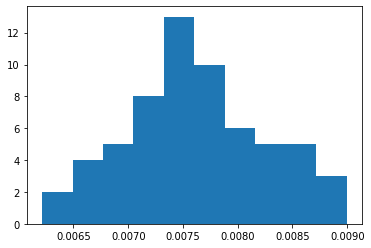

In [9]:
plt.hist(coeffs_may)

In [6]:
# June
graphs_jun = []
coeffs_jun = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180621-1") and file.endswith(".hdf5"):
        graphs_jun.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs_jun):
    coeffs_jun.append(nx.average_clustering(g))

100%|██████████| 61/61 [1:20:36<00:00, 79.28s/it]


(array([ 7.,  3.,  6.,  7.,  9., 12.,  5.,  7.,  4.,  1.]),
 array([0.00781545, 0.00804225, 0.00826905, 0.00849585, 0.00872265,
        0.00894945, 0.00917625, 0.00940305, 0.00962985, 0.00985665,
        0.01008345]),
 <a list of 10 Patch objects>)

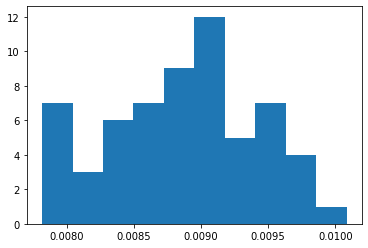

In [7]:
plt.hist(coeffs_jun)

In [ ]:
# July
graphs_jul = []
coeffs_jul = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180719-1") and file.endswith(".hdf5"):
        graphs_jul.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs_jul):
    coeffs_jul.append(nx.average_clustering(g))

In [ ]:
plt.hist(coeffs_jul)

In [ ]:
# August
graphs_aug = []
coeffs_aug = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180816-1") and file.endswith(".hdf5"):
        graphs_aug.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs_aug):
    coeffs_aug.append(nx.average_clustering(g))

In [ ]:
plt.hist(coeffs_aug)

In [ ]:
# September
graphs_sep = []
coeffs_sep = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180921-1") and file.endswith(".hdf5"):
        graphs_sep.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs_sep):
    coeffs_sep.append(nx.average_clustering(g))

In [ ]:
plt.hist(coeffs_sep)

In [ ]:
plt.hist(coeffs_sep + coeffs_aug + coeffs_jul)

In [ ]:
graphs = []
coeffs = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20181220-1") and file.endswith(".hdf5"):
        graphs.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs):
    coeffs.append(nx.average_clustering(g))

In [ ]:
plt.hist(coeffs)

In [ ]:
graphs_ = []
coeffs_ = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20181115-1") and file.endswith(".hdf5"):
        graphs_.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs_):
    coeffs_.append(nx.average_clustering(g))

In [ ]:
plt.hist(coeffs_)

In [ ]:
graphs__ = []
coeffs__ = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20181018-1") and file.endswith(".hdf5"):
        graphs__.append(dd.io.load(os.path.join(prefix, file)))

for g in tqdm(graphs__):
    coeffs__.append(nx.average_clustering(g))

In [15]:
mapping = {}

In [ ]:
# Sept names
names = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180921-1") and file.endswith(".hdf5"):
        names.append(file)

for n, c in zip(names, coeffs_sep):
    mapping[n] = c

In [ ]:
# Aug names
names = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180816-1") and file.endswith(".hdf5"):
        names.append(file)

for n, c in zip(names, coeffs_aug):
    mapping[n] = c

In [ ]:
# July names
names = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180719-1") and file.endswith(".hdf5"):
        names.append(file)

for n, c in zip(names, coeffs_jul):
    mapping[n] = c

In [13]:
# June names
names = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180621-1") and file.endswith(".hdf5"):
        names.append(file)

for n, c in zip(names, coeffs_jun):
    mapping[n] = c

100%|██████████| 752/752 [00:00<00:00, 712633.67it/s]


In [16]:
# May names
names = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180517-1") and file.endswith(".hdf5"):
        names.append(file)

for n, c in zip(names, coeffs_may):
    mapping[n] = c

100%|██████████| 752/752 [00:00<00:00, 656970.76it/s]


In [17]:
for k, v in mapping.items():
    print(k + "," + str(v))

equinix-nyc.dirA.20180517-134300.UTC.anon.hdf5,0.008641125031337972
equinix-nyc.dirA.20180517-132000.UTC.anon.hdf5,0.008035042710738925
equinix-nyc.dirA.20180517-130100.UTC.anon.hdf5,0.007928334029823889
equinix-nyc.dirA.20180517-135300.UTC.anon.hdf5,0.007194124321608037
equinix-nyc.dirA.20180517-131100.UTC.anon.hdf5,0.008461216247748956
equinix-nyc.dirA.20180517-133000.UTC.anon.hdf5,0.0077639481243399885
equinix-nyc.dirA.20180517-130000.UTC.anon.hdf5,0.007295496905872347
equinix-nyc.dirA.20180517-132100.UTC.anon.hdf5,0.007570190779217938
equinix-nyc.dirA.20180517-134200.UTC.anon.hdf5,0.0073511497735330895
equinix-nyc.dirA.20180517-133100.UTC.anon.hdf5,0.00656808199470967
equinix-nyc.dirA.20180517-131000.UTC.anon.hdf5,0.008895267620465446
equinix-nyc.dirA.20180517-135200.UTC.anon.hdf5,0.007275882830097168
equinix-nyc.dirA.20180517-131300.UTC.anon.hdf5,0.00899363964643712
equinix-nyc.dirA.20180517-133200.UTC.anon.hdf5,0.00749146555044486
equinix-nyc.dirA.20180517-135100.UTC.anon.hdf5,0.

In [ ]:
# Oct names
names__ = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20181018-1") and file.endswith(".hdf5"):
        names__.append(file)

for n, c in zip(names__, coeffs__):
    mapping[n] = c

In [ ]:
# Nov names
names_ = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20181115-1") and file.endswith(".hdf5"):
        names_.append(file)

for n, c in zip(names_, coeffs_):
    mapping[n] = c

In [ ]:
# Dec names
names = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20181220-1") and file.endswith(".hdf5"):
        names.append(file)

for n, c in zip(names, coeffs):
    mapping[n] = c

In [ ]:
# Write to file
with open("./coeffs.csv", 'w') as f:
    for k, v in mapping.items():
        f.write(k + "," + str(v) + "\n")

In [ ]:
plt.hist(coeffs__)

In [ ]:
plt.hist(coeffs__ + coeffs_ + coeffs, bins=20)

## See if clustering coeffs could be correlated with nodes/edges

In [ ]:
plt.plot([g.number_of_nodes() for g in graphs__], coeffs__, 'o')

In [ ]:
plt.plot([g.number_of_edges() for g in graphs__], coeffs__, 'o')

In [ ]:
plt.plot([g.number_of_nodes() for g in graphs_], coeffs_, 'o')

In [ ]:
plt.plot([g.number_of_edges() for g in graphs_], coeffs_, 'o')

In [ ]:
plt.plot([g.number_of_nodes() for g in graphs], coeffs, 'o')

In [ ]:
plt.plot([g.number_of_edges() for g in graphs], coeffs, 'o')

In [ ]:
plt.plot([g.number_of_nodes() for g in graphs_sep], coeffs_sep, 'o')

In [ ]:
plt.plot([g.number_of_edges() for g in graphs_sep], coeffs_sep, 'o')

In [ ]:
plt.plot([g.number_of_nodes() for g in graphs_aug], coeffs_aug, 'o')

In [ ]:
plt.plot([g.number_of_edges() for g in graphs_aug], coeffs_aug, 'o')

In [ ]:
plt.plot([g.number_of_nodes() for g in graphs_jul], coeffs_jul, 'o')

In [ ]:
plt.plot([g.number_of_edges() for g in graphs_jul], coeffs_jul, 'o')

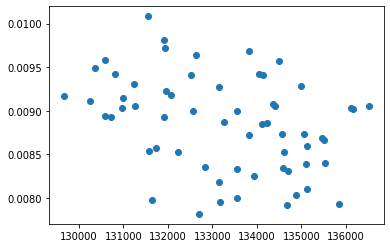

In [20]:
plt.plot([g.number_of_nodes() for g in graphs_jun], coeffs_jun, 'o')

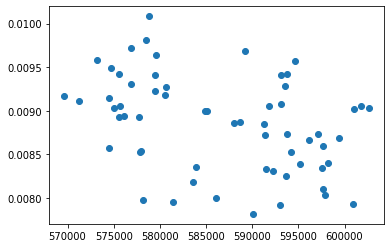

In [21]:
plt.plot([g.number_of_edges() for g in graphs_jun], coeffs_jun, 'o')

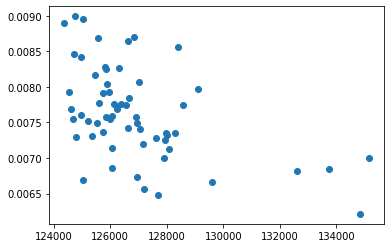

In [22]:
plt.plot([g.number_of_nodes() for g in graphs_may], coeffs_may, 'o')

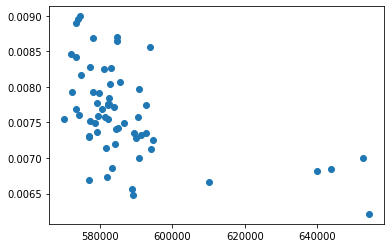

In [23]:
plt.plot([g.number_of_edges() for g in graphs_may], coeffs_may, 'o')

In [ ]:
graphs = []
coeffs = []
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20181220-1") and file.endswith(".hdf5"):
        graphs.append(dd.io.load(os.path.join(prefix, file)))
        coeffs.append(nx.average_clustering(g))

In [ ]:
modify_clustering_coefficient(graph_c, 0.005, verbose=True)

In [26]:
# Save to May
graphs_to_save = {}

i = 0
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180517-1") and file.endswith(".hdf5"):
        graphs_to_save[file] = graphs_may[i]
        i += 1

assert i == len(graphs_may)

100%|██████████| 753/753 [00:00<00:00, 690794.16it/s]


In [27]:
dd.io.save(prefix + "all_graphs_may.hdf5", graphs_to_save)

/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-134300.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-132000.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-130100.UTC.anon.hdf5'; it does not match the patt

/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-131200.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-134000.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-130200.UTC.anon.hdf5'; it does not match the patt

/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-132700.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-131800.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180517-133900.UTC.anon.hdf5'; it does not match the patt

In [24]:
# Save to June
graphs_to_save = {}

i = 0
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180621-1") and file.endswith(".hdf5"):
        graphs_to_save[file] = graphs_jun[i]
        i += 1

assert i == len(graphs_jun)

100%|██████████| 752/752 [00:00<00:00, 648194.95it/s]


In [25]:
dd.io.save(prefix + "all_graphs_jun.hdf5", graphs_to_save)

/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-132400.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-130500.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-134700.UTC.anon.hdf5'; it does not match the patt

/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-134500.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-132600.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-131900.UTC.anon.hdf5'; it does not match the patt

/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-133000.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-131100.UTC.anon.hdf5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'equinix-nyc.dirA.20180621-135300.UTC.anon.hdf5'; it does not match the patt

In [ ]:
# Save july
graphs_to_save = {}

i = 0
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180719-1") and file.endswith(".hdf5"):
        graphs_to_save[file] = graphs_jul[i]
        i += 1

assert i == len(graphs_jul)

In [ ]:
dd.io.save(prefix + "all_graphs_jul.hdf5", graphs_to_save)

In [ ]:
# Save august
graphs_to_save = {}

i = 0
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180816-1") and file.endswith(".hdf5"):
        graphs_to_save[file] = graphs_aug[i]
        i += 1

assert i == len(graphs_aug)

In [ ]:
dd.io.save(prefix + "all_graphs_aug.hdf5", graphs_to_save)

In [ ]:
# Save september
graphs_to_save = {}

i = 0
for file in tqdm(os.listdir(prefix)):
    if file.startswith("equinix-nyc.dirA.20180921-1") and file.endswith(".hdf5"):
        graphs_to_save[file] = graphs_sep[i]
        i += 1

assert i == len(graphs_sep)

In [ ]:
dd.io.save(prefix + "all_graphs_sep.hdf5", graphs_to_save)

## Open all hdf5 graphs, combine into one file

In [ ]:
graphs_to_save = {}
for file in tqdm(os.listdir(prefix)):
    if file.endswith(".hdf5"):
        graphs_to_save[file] = dd.io.load(os.path.join(prefix, file))

In [ ]:
dd.io.save(prefix + "all_graphs.hdf5", graphs_to_save)

In [ ]:
dd.io.load(prefix + "all_graphs.hdf5")

In [ ]:
graph_c = g.copy()

In [ ]:
%%time

modify_clustering_coefficient(graph_c, 0.005, verbose=False)

In [ ]:
graph_c = g.copy()

In [ ]:
%%time

modify_clustering_coefficient(graph_c, 0.004, verbose=False)

In [ ]:
%%time

cc = nx.average_clustering(g)

In [ ]:
%%time

dmm = nx.algorithms.assortativity.degree_mixing_matrix(g)

In [ ]:
%%time

dmm = nx.algorithms.assortativity.degree_mixing_matrix(g)
eigenvals = np.linalg.eigvals(dmm)

mixing_rate = np.log(1/eigenvals[1])
mixing_rate